<a href="https://colab.research.google.com/github/skaghzz/A.I-Assignment/blob/master/1.cifar-10/%EA%B9%80%EB%82%A8%ED%98%B8/sub_problem_3/2_CIFAR10_fineTuning_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://jjeongil.tistory.com/855

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import os

import cv2

tf.__version__

'2.3.0'

In [2]:
# hyperparameter
batch_size = 50
epochs =40
learning_rate = 0.0001

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train_ori = x_train.copy()
y_train_ori = y_train.copy()

#x_train = tf.image.resize(x_train, [72, 72])
#x_train_ori = tf.image.resize(x_train_ori, [72, 72])

x_aug_train, x_aug_valid, y_aug_train, y_aug_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)
x_ori_train, x_ori_valid, y_ori_train, y_ori_valid = train_test_split(x_train_ori, y_train_ori, test_size=0.2, shuffle=True)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [4]:
augmented_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,  ## 무작위 회전 각도 범위
    width_shift_range=0.2, ## 가로로 이동 비율
    height_shift_range=0.2,  ## 세로로 이동 비율
    shear_range=0.2,  # 층밀리기의 강도
    zoom_range=0.2, ## 확대 와 축소 범위 [1-0.1 ~ 1+0.1 ]
    horizontal_flip=True, ## 수평기준 플립
    #vertical_flip=True,
    #validation_split=0.2, # 검증의 용도로 남겨둘 남겨둘 이미지의 비율
)

augmented_train_datagen.fit(x_aug_train, augment=True)

x_train = tf.concat([x_aug_train, x_ori_train],0)
y_train = tf.concat([y_aug_train, y_ori_train],0)
x_valid = tf.concat([x_aug_valid, x_ori_valid],0)
y_valid = tf.concat([y_aug_valid, y_ori_valid],0)
train_gen_flow = augmented_train_datagen.flow(x_ori_train, y_ori_train, batch_size=batch_size)
valid_gen_flow = augmented_train_datagen.flow(x_ori_valid, y_ori_valid, batch_size=batch_size)
print(len(train_gen_flow))
print(len(valid_gen_flow))

800
200


In [5]:
checkpoint_dir = 'cifar10_classification/exp1'
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
cos_decay = tf.keras.experimental.CosineDecay(learning_rate, epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)
early_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [6]:
# 사전 훈련된 모델 Xception에서 기본 모델을 생성합니다.
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', pooling='avg', input_shape=(32,32,3))
base_model.trainable = True
base_model.summary()

set_trainable = False
for layer in base_model.layers:
  if layer.name == 'conv5_block3_3_conv':
    set_trainable =  True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
# 모델

input_layer = tf.keras.layers.Input(shape=(32,32,3))
x = base_model(input_layer)
#x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dense(1024, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.5)(x)
out_layer = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
model.summary()
model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [7]:
history = model.fit(
    train_gen_flow,
    steps_per_epoch= len(train_gen_flow),
    epochs=epochs,
    validation_data=valid_gen_flow,
    validation_steps = len(valid_gen_flow),
    callbacks=[cp_callback, lr_callback, early_callback]
)


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(1e-04, shape=(), dtype=float32).
Epoch 1/40
799/800 [============================>.] - ETA: 0s - loss: 2.0641 - sparse_categorical_accuracy: 0.2630
Epoch 00001: val_loss improved from inf to 2.98889, saving model to cifar10_classification/exp1
800/800 [==============================] - 31s 39ms/step - loss: 2.0640 - sparse_categorical_accuracy: 0.2630 - val_loss: 2.9889 - val_sparse_categorical_accuracy: 0.1825

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(9.9845856e-05, shape=(), dtype=float32).
Epoch 2/40
799/800 [============================>.] - ETA: 0s - loss: 1.9387 - sparse_categorical_accuracy: 0.3090
Epoch 00002: val_loss improved from 2.98889 to 2.91588, saving model to cifar10_classification/exp1
800/800 [==============================] - 30s 38ms/step - loss: 1.9387 - sparse_categorical_accuracy: 0.3090 - val_loss: 2.9159 - val_sparse_categorical_accuracy: 0.2117

Epoch 00003: 

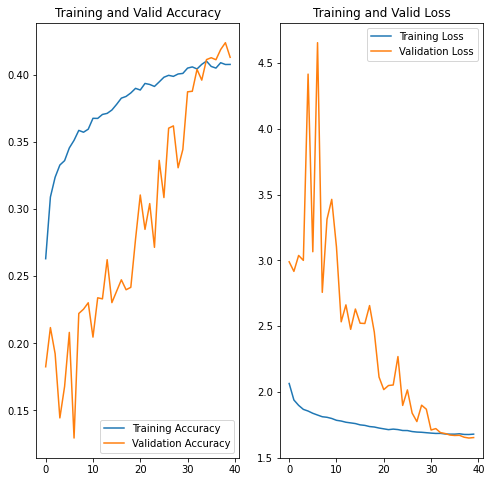

In [8]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Valid Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Valid Loss')
plt.show()

모델평가

In [9]:
results = model.evaluate(x_test, y_test, verbose=1)
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))

313/313 [==============================] - 3s 10ms/step - loss: 1.4789 - sparse_categorical_accuracy: 0.4898
loss value: 1.479
accuracy value: 48.9800%


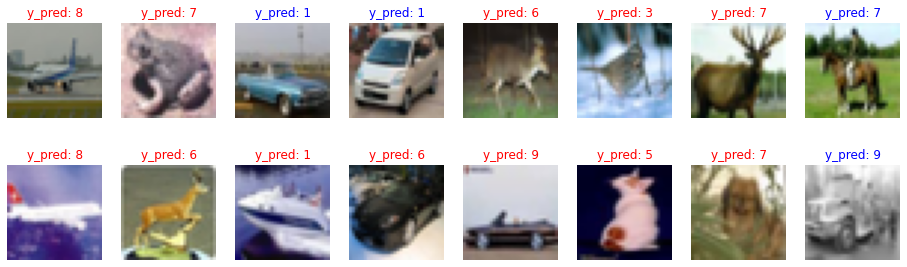

In [10]:
test_batch_size = 16
batch_index = np.random.choice(len(x_test), size=test_batch_size, replace=False)

batch_xs = x_test[batch_index]
batch_ys = y_test[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(32, 32, 3))
  p.axis('off')

In [11]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/saved_models/1604034697/assets


'/tmp/saved_models/1604034697'